In [1]:
%reload_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

import numpy as np
import healpy as hp
from astropy.io import fits
from pprint import pprint
from tqdm import tqdm
import pickle
import corner
import os

from scipy import optimize
from scipy.stats import poisson

import jax
import jax.numpy as jnp

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc_file('../utils/matplotlibrc')

from utils import ed_fcts as ef

In [2]:
# load SVI fit results (these should be the only parameters that you are loading)
gpu_id = '0'

# name of the synthetic directory
sim_name = 'canon_g1'

# load SVI fit results (these should be the only parameters that you are loading)
sim_id = 7.1234567
temp_id = 4.3457
gp_id = 1.126
blg_id = -1
mod_id = 0
svi_id = 0
sim_seed = 0
svi_seed = 0

In [3]:
# load GPU
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_id

data_dir = ef.load_data_dir(sim_name)
os.system("mkdir -p "+data_dir)

# Load the simulated templates
ebin = 10
temp_dict = np.load(data_dir + 'all_templates_ebin' + str(ebin)  + '.npy', allow_pickle=True).item()

In [4]:
fit_filename, module_name = ef.generate_fit_filename_from_ids(sim_id, temp_id, gp_id, blg_id, mod_id, svi_id, sim_seed, svi_seed)
fit_dir = data_dir + 'fits/' + fit_filename + '/'
ef.list_files(fit_dir)

sys.path.append(fit_dir)
import importlib 
module = importlib.import_module(module_name)

# Load all the variables from the module
globals().update(vars(module))

# load saved data from GP -> Data fit
gp_file_name = ('ebin' + str_ebin + '_smp_svi_' + 
             str_lr + '_' + str_n_steps + '_' + 
                str_guide + '_' + str_num_particles + '_' + 
                str_sim_seed + '_' + str_svi_seed + '.p')

if is_gp:
   samples, svi_results, gp_samples = pickle.load(open(fit_dir + gp_file_name, 'rb'))
else:
   samples, svi_results = pickle.load(open(fit_dir + gp_file_name, 'rb'))

# load saved data from Temps -> GP fit

## load fit settings for second step
ebin = 10
str_ebin = str(ebin)

guide = 'mvn'
str_guide = guide

n_steps = 15000
str_n_steps = str(n_steps)

lr = 0.02  
str_lr = str(lr)   # BE SURE TO CHANGE THIS

num_particles = 16
str_num_particles = str(num_particles)

svi_seed = 193
str_svi_seed = str(svi_seed)


if is_gp:
    temp_file_name = ('gp2temp_' + 'ebin' + str_ebin + '_smp_svi_' + 
            str_lr + '_' + str_n_steps + '_' + 
                str_guide + '_' + str_num_particles + '_' + 
                str_sim_seed + '_' + str_svi_seed + '.p')
    temp_samples, temp_svi_results = pickle.load(open(fit_dir + temp_file_name, 'rb'))

/
    gp2temp_ebin10_smp_svi_0.02_15000_mvn_16_0_193.p
    settings_7p1234567_4p3457_1p126_-1_0_0_0_0.py
    gp2temp_ebin10_svi_res_0.02_15000_mvn_16_0_193.p
    summary.txt
    __init__.py
    ebin10_smp_svi_0.1_15000_mvn_16_0_0.p
__pycache__/
    settings_7p1234567_4p3457_1p126_-1_0_0_0_0.cpython-311.pyc


/home/edr76/.conda/envs/jax/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# load model using stored parameters

from models.poissonian_ed import EbinPoissonModel # to set GPU at the beginning

ebinmodel = EbinPoissonModel(
        # all parameters
        rig_temp_list = rig_temp_list,
        hyb_temp_list = hyb_temp_list,
        var_temp_list = var_temp_list,
        is_gp = is_gp,
        gp_deriv = gp_deriv,
        data_file = data_file,
        rig_temp_sim = rig_temp_sim,
        hyb_temp_sim = hyb_temp_sim,
        var_temp_sim = var_temp_sim,
        is_custom_blg= is_custom_blg,
        custom_blg_id = custom_blg_id,
        sim_seed = sim_seed,
        Nu = Nu,
        u_option = u_option,
        u_grid_type = u_grid_type,
        u_weights = u_weights,
        Np = Np,
        p_option = p_option,
        Nsub = Nsub,
        ebin = ebin,
        is_float64 = is_float64,
        debug_nans = debug_nans,
        no_ps_mask = no_ps_mask,
        p_grid_type = p_grid_type,
        p_weights = p_weights,
        gp_kernel = gp_kernel,
        gp_params = gp_params,
        gp_scale_option = gp_scale_option,
        monotonicity_hyperparameter = monotonicity_hyperparameter,
        nfw_gamma =  nfw_gamma,
        blg_names = blg_names,
        )
ebinmodel.config_model(ebin=ebin)

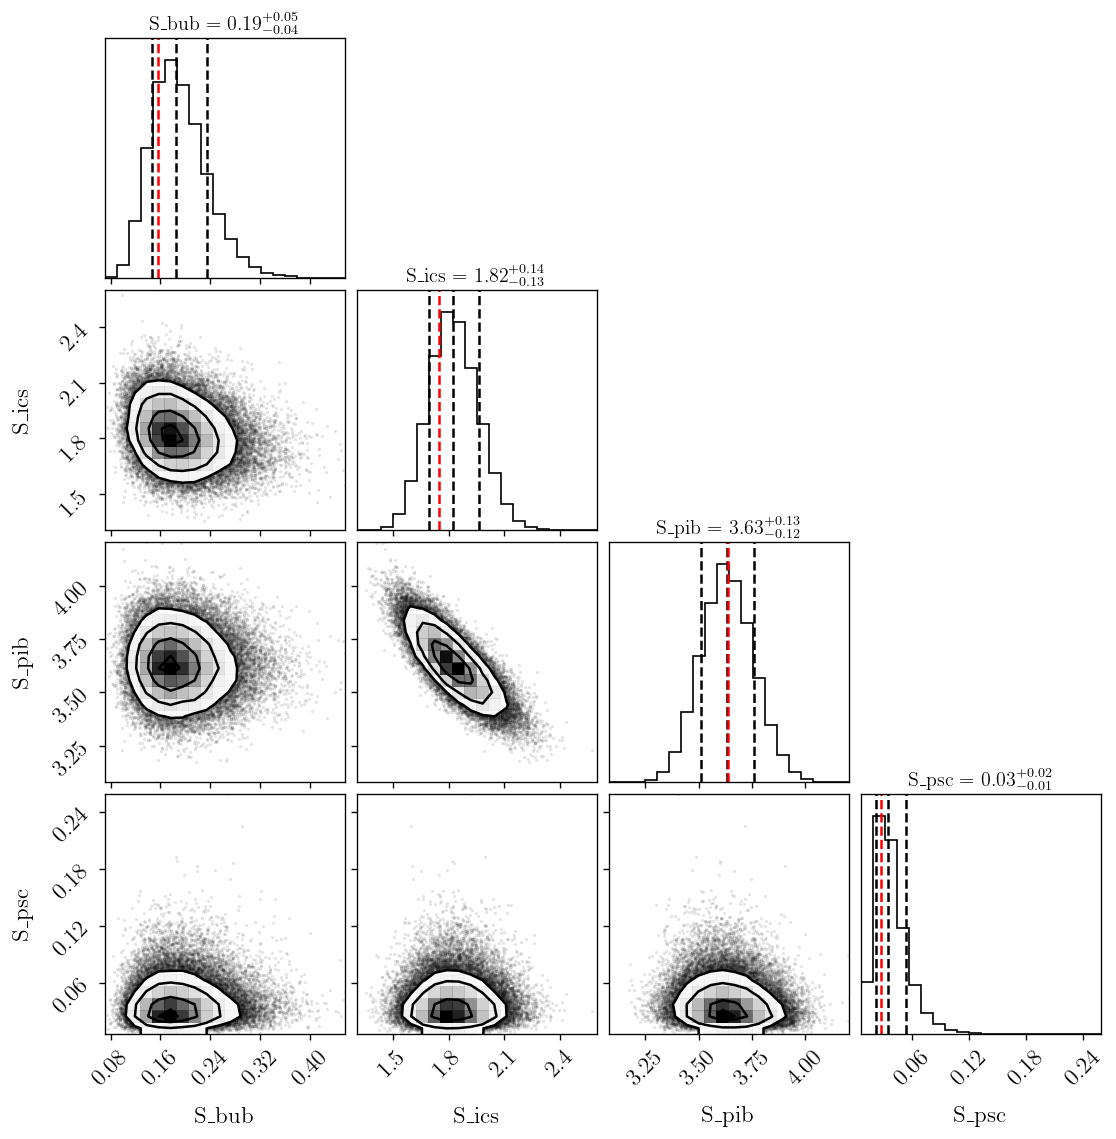

In [8]:
# gp fit background templates corner plot
fig = ef.make_corner_plots(samples, with_mean_vlines = False, sim_vlines = True, temp_dict = temp_dict)

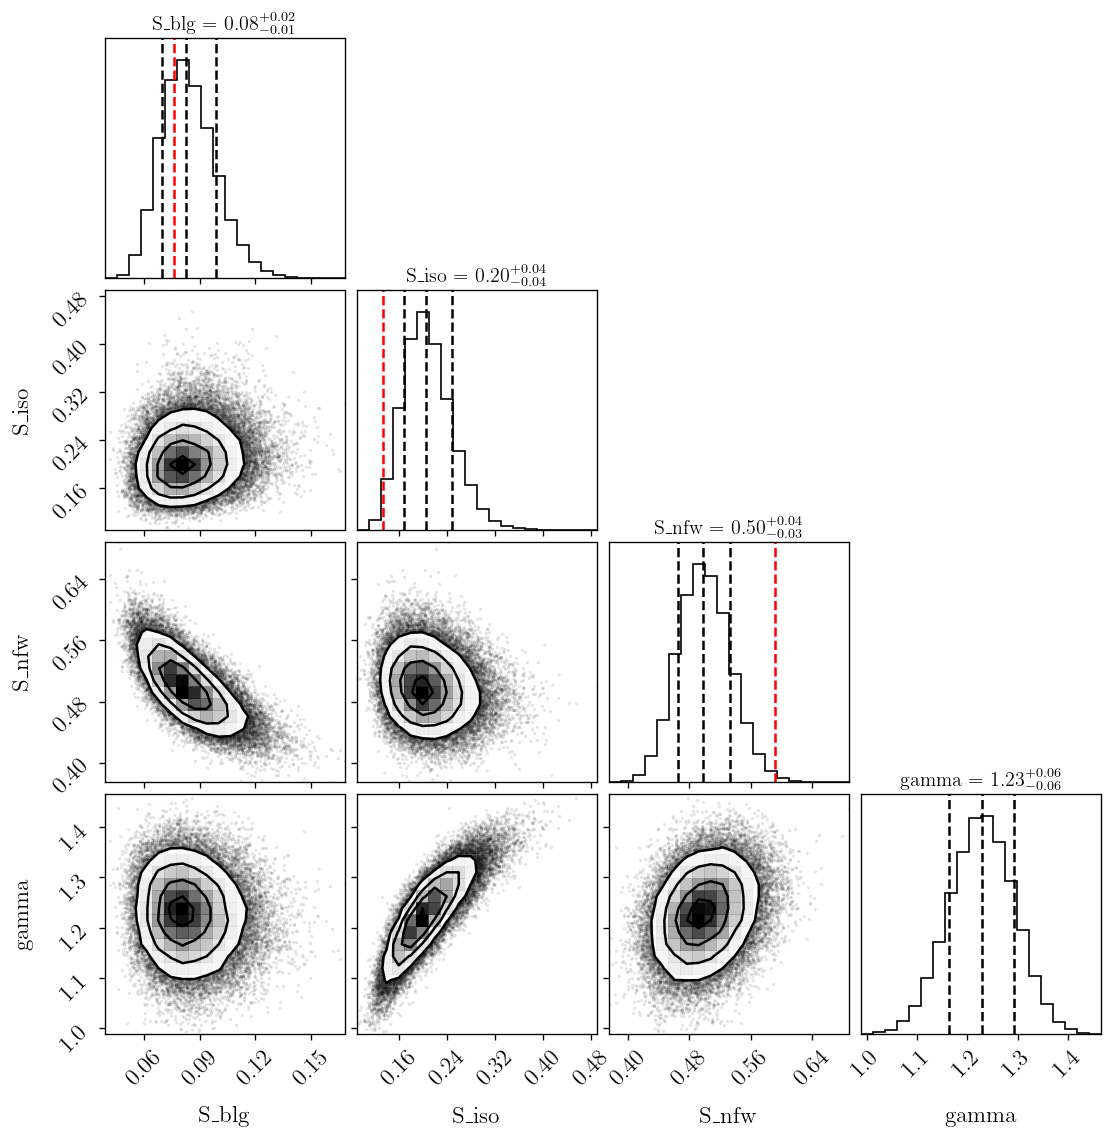

In [9]:
# temp fits corner plot
fig = ef.make_corner_plots(temp_samples, with_mean_vlines = False, sim_vlines = True, temp_dict = temp_dict)